In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
neurons = 256                 
activation_function = 'tanh'  
loss = 'mse'                  
optimizer= 'adam'             
dropout = 0.40               
batch_size = 60              
epochs = 150                
window_len = 7              
training_size = 0.8          
merge_date = '2016-05-03'     

In [3]:
def get_market_data(market):
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  market_data.columns = [market_data.columns[0]] + ["BTC" + '_' + i for i in market_data.columns[1:]]
  return market_data


def cut_data(data, from_date=merge_date):
  cut_data = data[data['Date'] >= from_date]
  cut_data = cut_data.sort_values(by='Date')
  return cut_data


def split_data(data, training_size=training_size):
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, window_len=window_len):
  norm_cols = ['BTC_Open*', 'BTC_Close**', 'BTC_Volume', 'BTC_High', 'BTC_Low', 'BTC_Market Cap']
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, window_len=window_len):
  return (data['BTC_Close**'][window_len:].values / data['BTC_Close**'][:-window_len].values) - 1


def to_array(data):
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)

def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [4]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]

def plot_results(history, model):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title('Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_train)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title('Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(Y_test)
  plt.plot(model.predict(X_test))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title('Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

In [5]:
market_data = get_market_data("bitcoin")

In [6]:
model_data = cut_data(market_data)
train_set, test_set = split_data(model_data)

train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)


In [7]:
model_data.head()

,Date,BTC_Open*,BTC_High,BTC_Low,BTC_Close**,BTC_Volume,BTC_Market Cap
785,2016-05-03,444.73,451.10,442.62,450.30,59366400.0,6892690000
784,2016-05-04,450.18,450.38,445.63,446.72,50407300.0,6978950000
783,2016-05-05,446.71,448.51,445.88,447.98,50440800.0,6926990000
782,2016-05-06,447.94,461.38,447.07,459.60,72796800.0,6947800000
781,2016-05-07,459.64,460.68,457.32,458.54,38364500.0,7131120000


In [8]:
X_train = create_inputs(train_set)
Y_train = create_outputs(train_set)
X_test = create_inputs(test_set)
Y_test = create_outputs(test_set)

X_train, X_test = to_array(X_train), to_array(X_test)

print(X_train)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.22546264e-02 -1.59609843e-03  6.80041571e-03 -7.95025539e-03
   -1.50911964e-01  1.25147076e-02]
  [ 4.45213950e-03 -5.74152073e-03  7.36523429e-03 -5.15212081e-03
   -1.50347671e-01  4.97628647e-03]
  ...
  [ 3.35259596e-02  2.12369763e-02  3.32113325e-02  1.82989118e-02
   -3.53767451e-01  3.45917196e-02]
  [ 3.08052077e-02  1.84438040e-02  3.01839049e-02  1.83211193e-02
   -3.20912166e-01  3.21166337e-02]
  [ 3.03105255e-02  2.52272223e-02  3.14265058e-02  2.26071508e-02
   -6.52439764e-02  3.18917578e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-7.70802790e-03 -4.15204938e-03  5.61003523e-04  2.82055874e-03
    6.64586280e-04 -7.44524606e-03]
  [-4.97578746e-03  2.44238199e-02  3.23138029e-03  2.88323782e-02
    4.44171777e-01 -4.46342215e-03]
  ...
  [ 1.83260029e-02  2.00719393e-02  2.32255459e-02  2.64819

In [9]:
btc_model = build_model(X_train, output_size=1, neurons=neurons)

btc_history = btc_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 256)            269312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
__________

Epoch 42/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0026 - mean_absolute_error: 0.0353 - val_loss: 0.0029 - val_mean_absolute_error: 0.0411
Epoch 43/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0027 - mean_absolute_error: 0.0358 - val_loss: 0.0023 - val_mean_absolute_error: 0.0353
Epoch 44/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0343 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355
Epoch 45/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0023 - mean_absolute_error: 0.0328 - val_loss: 0.0026 - val_mean_absolute_error: 0.0371
Epoch 46/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0026 - mean_absolute_error: 0.0349 - val_loss: 0.0023 - val_mean_absolute_error: 0.0350
Epoch 47/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0344 - val_loss: 0.0025 - val_mean_absolute_error: 0.0368
Epoc

621/621 [==============================] - 1s 2ms/step - loss: 0.0026 - mean_absolute_error: 0.0340 - val_loss: 0.0024 - val_mean_absolute_error: 0.0356
Epoch 92/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0335 - val_loss: 0.0024 - val_mean_absolute_error: 0.0360
Epoch 93/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0335 - val_loss: 0.0026 - val_mean_absolute_error: 0.0374
Epoch 94/150
621/621 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_absolute_error: 0.0343 - val_loss: 0.0022 - val_mean_absolute_error: 0.0344
Epoch 95/150
621/621 [==============================] - 1s 1ms/step - loss: 0.0021 - mean_absolute_error: 0.0320 - val_loss: 0.0024 - val_mean_absolute_error: 0.0361
Epoch 96/150
621/621 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_absolute_error: 0.0337 - val_loss: 0.0026 - val_mean_absolute_error: 0.0377
Epoch 97/150
621/

621/621 [==============================] - 1s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0325 - val_loss: 0.0024 - val_mean_absolute_error: 0.0361
Epoch 141/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0023 - mean_absolute_error: 0.0329 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371
Epoch 142/150
621/621 [==============================] - 1s 1ms/step - loss: 0.0022 - mean_absolute_error: 0.0325 - val_loss: 0.0024 - val_mean_absolute_error: 0.0356
Epoch 143/150
621/621 [==============================] - 1s 1ms/step - loss: 0.0021 - mean_absolute_error: 0.0331 - val_loss: 0.0023 - val_mean_absolute_error: 0.0353
Epoch 144/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0311 - val_loss: 0.0025 - val_mean_absolute_error: 0.0366
Epoch 145/150
621/621 [==============================] - 1s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0319 - val_loss: 0.0026 - val_mean_absolute_error: 0.0379
Epoch 146/15

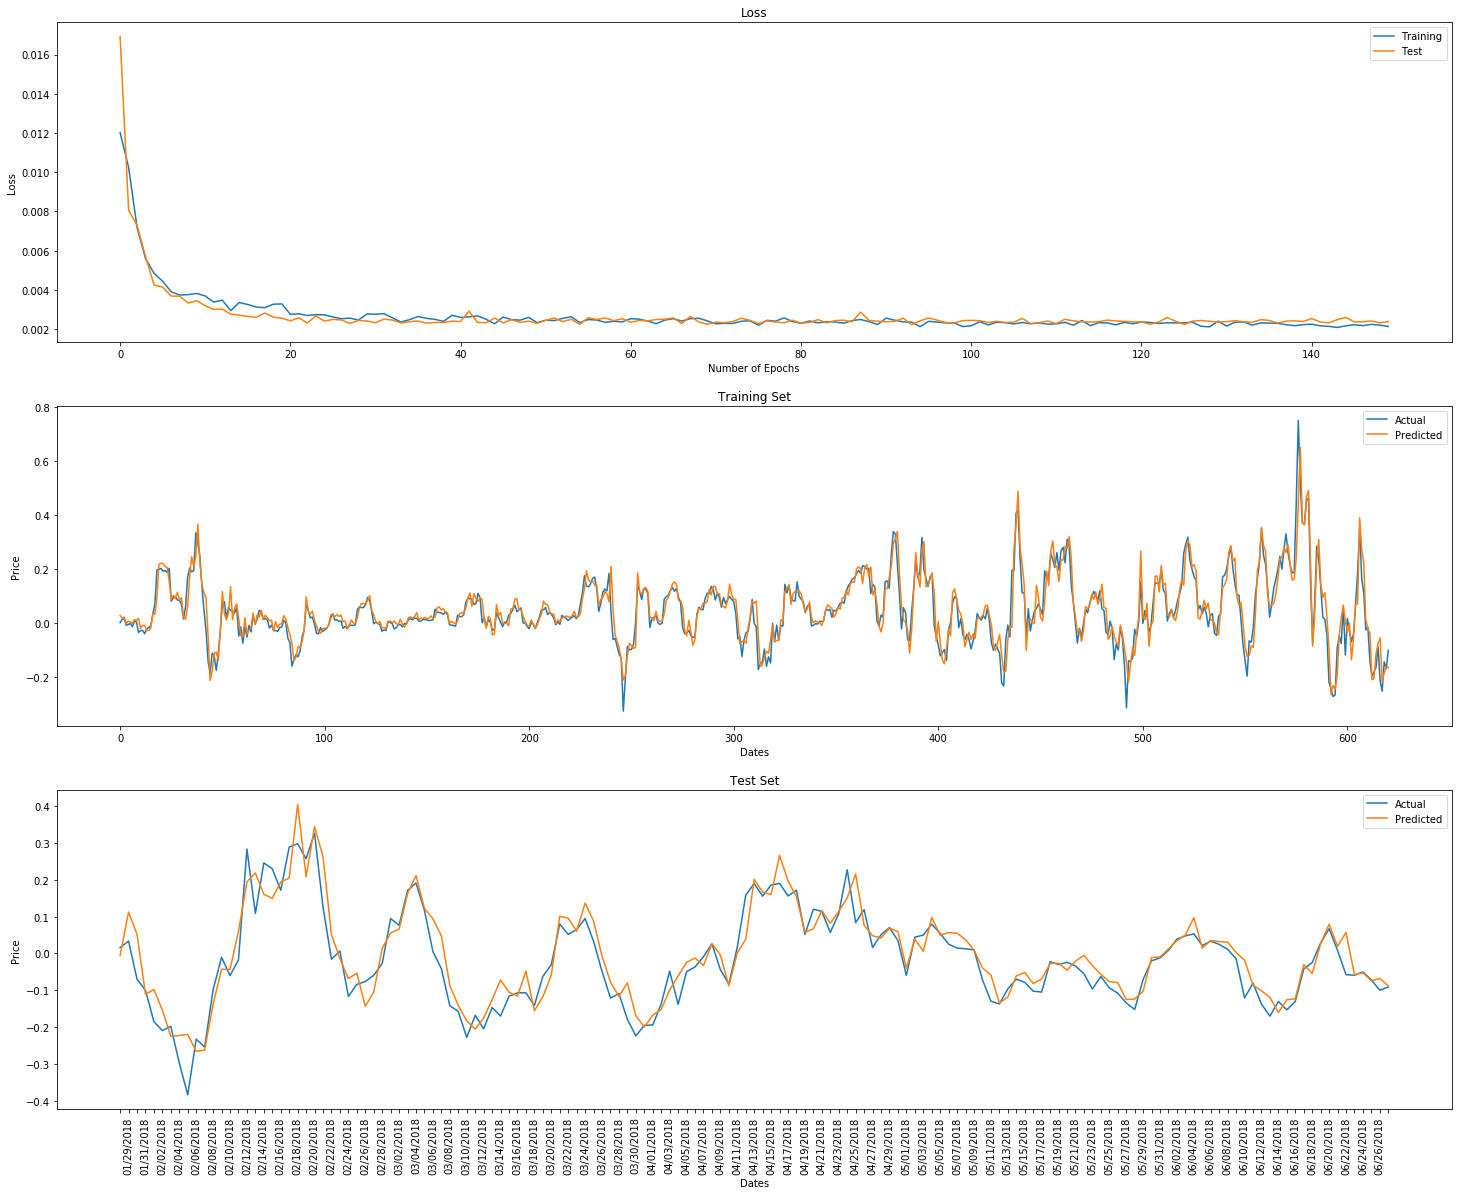

In [10]:
plot_results(btc_history, btc_model)